In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd

from lib.model import FNO1d
from lib.utils import relative_l2_error, calculate_errors
from lib.dataset import PDEDatasetAll2All

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
DEVICE = "cpu"

In [5]:
modes = 16
width = 64
layers = 4
fno = FNO1d(modes, width, layers).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model.pth", weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
time_pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
dataset = (
    PDEDatasetAll2All(
        "data/test_allen_cahn_fourier.npz", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_gmm.npz", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_piecewise.npz", device=DEVICE, time_pairs=time_pairs
    )
)

errors, test_relative_l2 = calculate_errors(fno, dataset)
print(rf"Test Relative L2 error: {test_relative_l2}")

100%|██████████| 29/29 [00:12<00:00,  2.39it/s]

Test Relative L2 error: 0.023528115165730317


In [7]:
time_pairs = [(0, 4)]
dataset_fourier = PDEDatasetAll2All(
    "data/test_allen_cahn_fourier.npz", device=DEVICE, time_pairs=time_pairs
)


errors_fourier, test_fourier_relative_l2 = calculate_errors(fno, dataset_fourier)
print(rf"Test Relative L2 error: {test_fourier_relative_l2}")

100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

Test Relative L2 error: 0.023741348187128704


In [8]:
time_pairs = [(0, 4)]
dataset_gmm = PDEDatasetAll2All(
    "data/test_allen_cahn_gmm.npz", device=DEVICE, time_pairs=time_pairs
)

errors_gmm, test_gmm_relative_l2 = calculate_errors(fno, dataset_gmm)
print(rf"Test Relative L2 error: {test_gmm_relative_l2}")

100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

Test Relative L2 error: 0.014881378014882405


In [9]:
time_pairs = [(0, 4)]
dataset_piecewise = PDEDatasetAll2All(
    "data/test_allen_cahn_piecewise.npz", device=DEVICE, time_pairs=time_pairs
)

errors_piecewise, test_piecewise_relative_l2 = calculate_errors(fno, dataset_piecewise)
print(rf"Test Relative L2 error: {test_piecewise_relative_l2}")

100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

Test Relative L2 error: 0.03247249603271484


In [10]:
errors_piecewise

,dt,l2_error,epsilon
0,0.10,0.007291,0.10
1,0.02,0.169287,0.02
2,0.02,0.043824,0.02
3,0.05,0.003873,0.05
4,0.02,0.005049,0.02
...,...,...,...
145,0.02,0.044054,0.02
146,0.10,0.022932,0.10
147,0.02,0.010517,0.02
148,0.05,0.003865,0.05


In [11]:
errors_gmm

,dt,l2_error,epsilon
0,0.05,0.017090,0.05
1,0.05,0.021584,0.05
2,0.05,0.006632,0.05
3,0.05,0.004439,0.05
4,0.05,0.006077,0.05
...,...,...,...
145,0.10,0.006075,0.10
146,0.02,0.004553,0.02
147,0.02,0.020019,0.02
148,0.05,0.005316,0.05


In [12]:
df = pd.DataFrame(errors)
df["epsilon_s"] = df["epsilon"].apply(lambda x: f"{x:.3f}")
df["dt_s"] = df["dt"].apply(lambda x: f"{x:.3f}")
# sort by dt
df = df.sort_values(by="dt")
df

,dt,l2_error,epsilon,epsilon_s,dt_s
550,0.005,0.005719,0.02,0.020,0.005
1530,0.005,0.009584,0.02,0.020,0.005
875,0.005,0.004837,0.02,0.020,0.005
1326,0.005,0.002725,0.02,0.020,0.005
1109,0.005,0.004408,0.02,0.020,0.005
...,...,...,...,...,...
142,0.100,0.006487,0.10,0.100,0.100
763,0.100,0.003025,0.10,0.100,0.100
761,0.100,0.007294,0.10,0.100,0.100
1673,0.100,0.010521,0.10,0.100,0.100


In [13]:
# calculate mean error for each dt
mean_error_dt = df.groupby(pd.cut(df["dt"], bins=20), observed=True)["l2_error"].mean().reset_index()
mean_error_dt["dt"] = mean_error_dt["dt"].apply(lambda x: f"{x.mid:.3f}")
mean_error_dt

,dt,l2_error
0,0.007,0.023343
1,0.012,0.021655
2,0.017,0.023580
3,0.022,0.024093
4,0.026,0.022655
5,0.036,0.016770
6,0.050,0.025539
7,0.074,0.029646
8,0.098,0.025207


<Axes: xlabel='dt', ylabel='l2_error'>

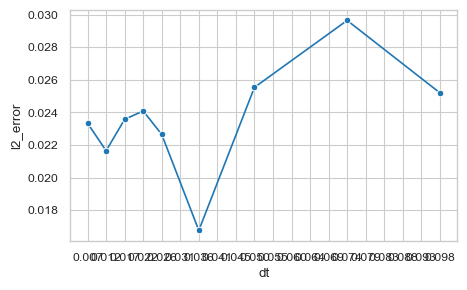

In [14]:
# plot the error
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=mean_error_dt, x="dt", y="l2_error", ax=ax, marker="o")

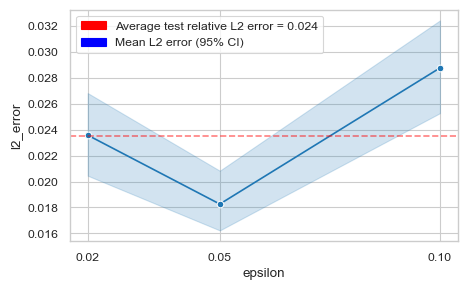

In [15]:
# plot mean_error_eps
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=df, x="epsilon", y="l2_error", ax=ax, marker="o")
# set ticks to epsilon
ax.set_xticks(df["epsilon"].unique())

plt.axhline(y=test_relative_l2, color="r", linestyle="--", alpha=0.5)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=f"Average test relative L2 error = {test_relative_l2:.3f}"),
        Patch(facecolor="b", edgecolor="b", label="Mean L2 error (95% CI)"),
    ]
)
plt.savefig("figures/test_error_vs_epsilon.png", dpi=300)
plt.show()

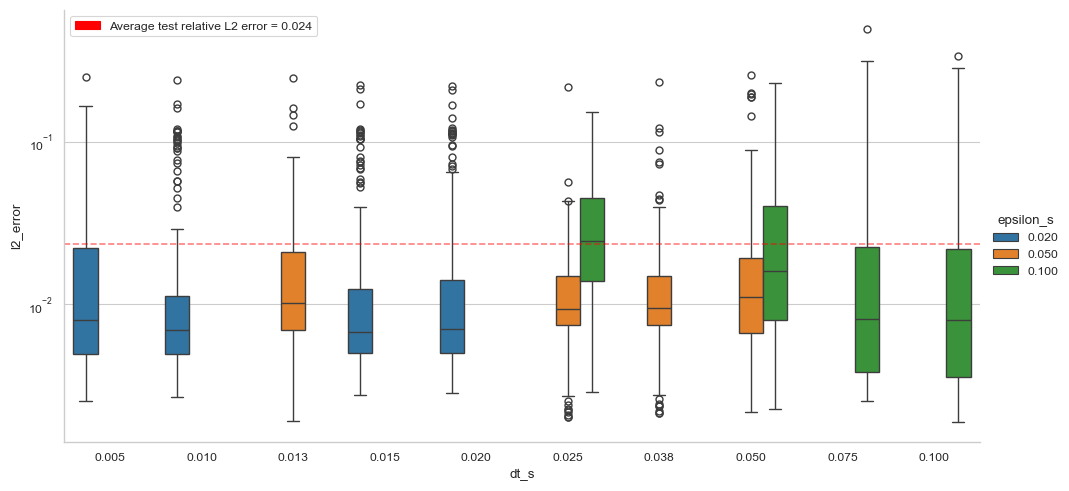

In [16]:
sns.catplot(
    data=df,
    x="dt_s",
    y="l2_error",
    log_scale=True,
    hue="epsilon_s",
    height=5,
    aspect=2,
    kind="box",
)
# draw a horizontal line at the OOD relative L2 error
plt.axhline(y=test_relative_l2, color="r", linestyle="--", alpha=0.5)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=f"Average test relative L2 error = {test_relative_l2:.3f}"),
    ]
)


In [17]:
BATCH_SIZE = 5
sampler = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

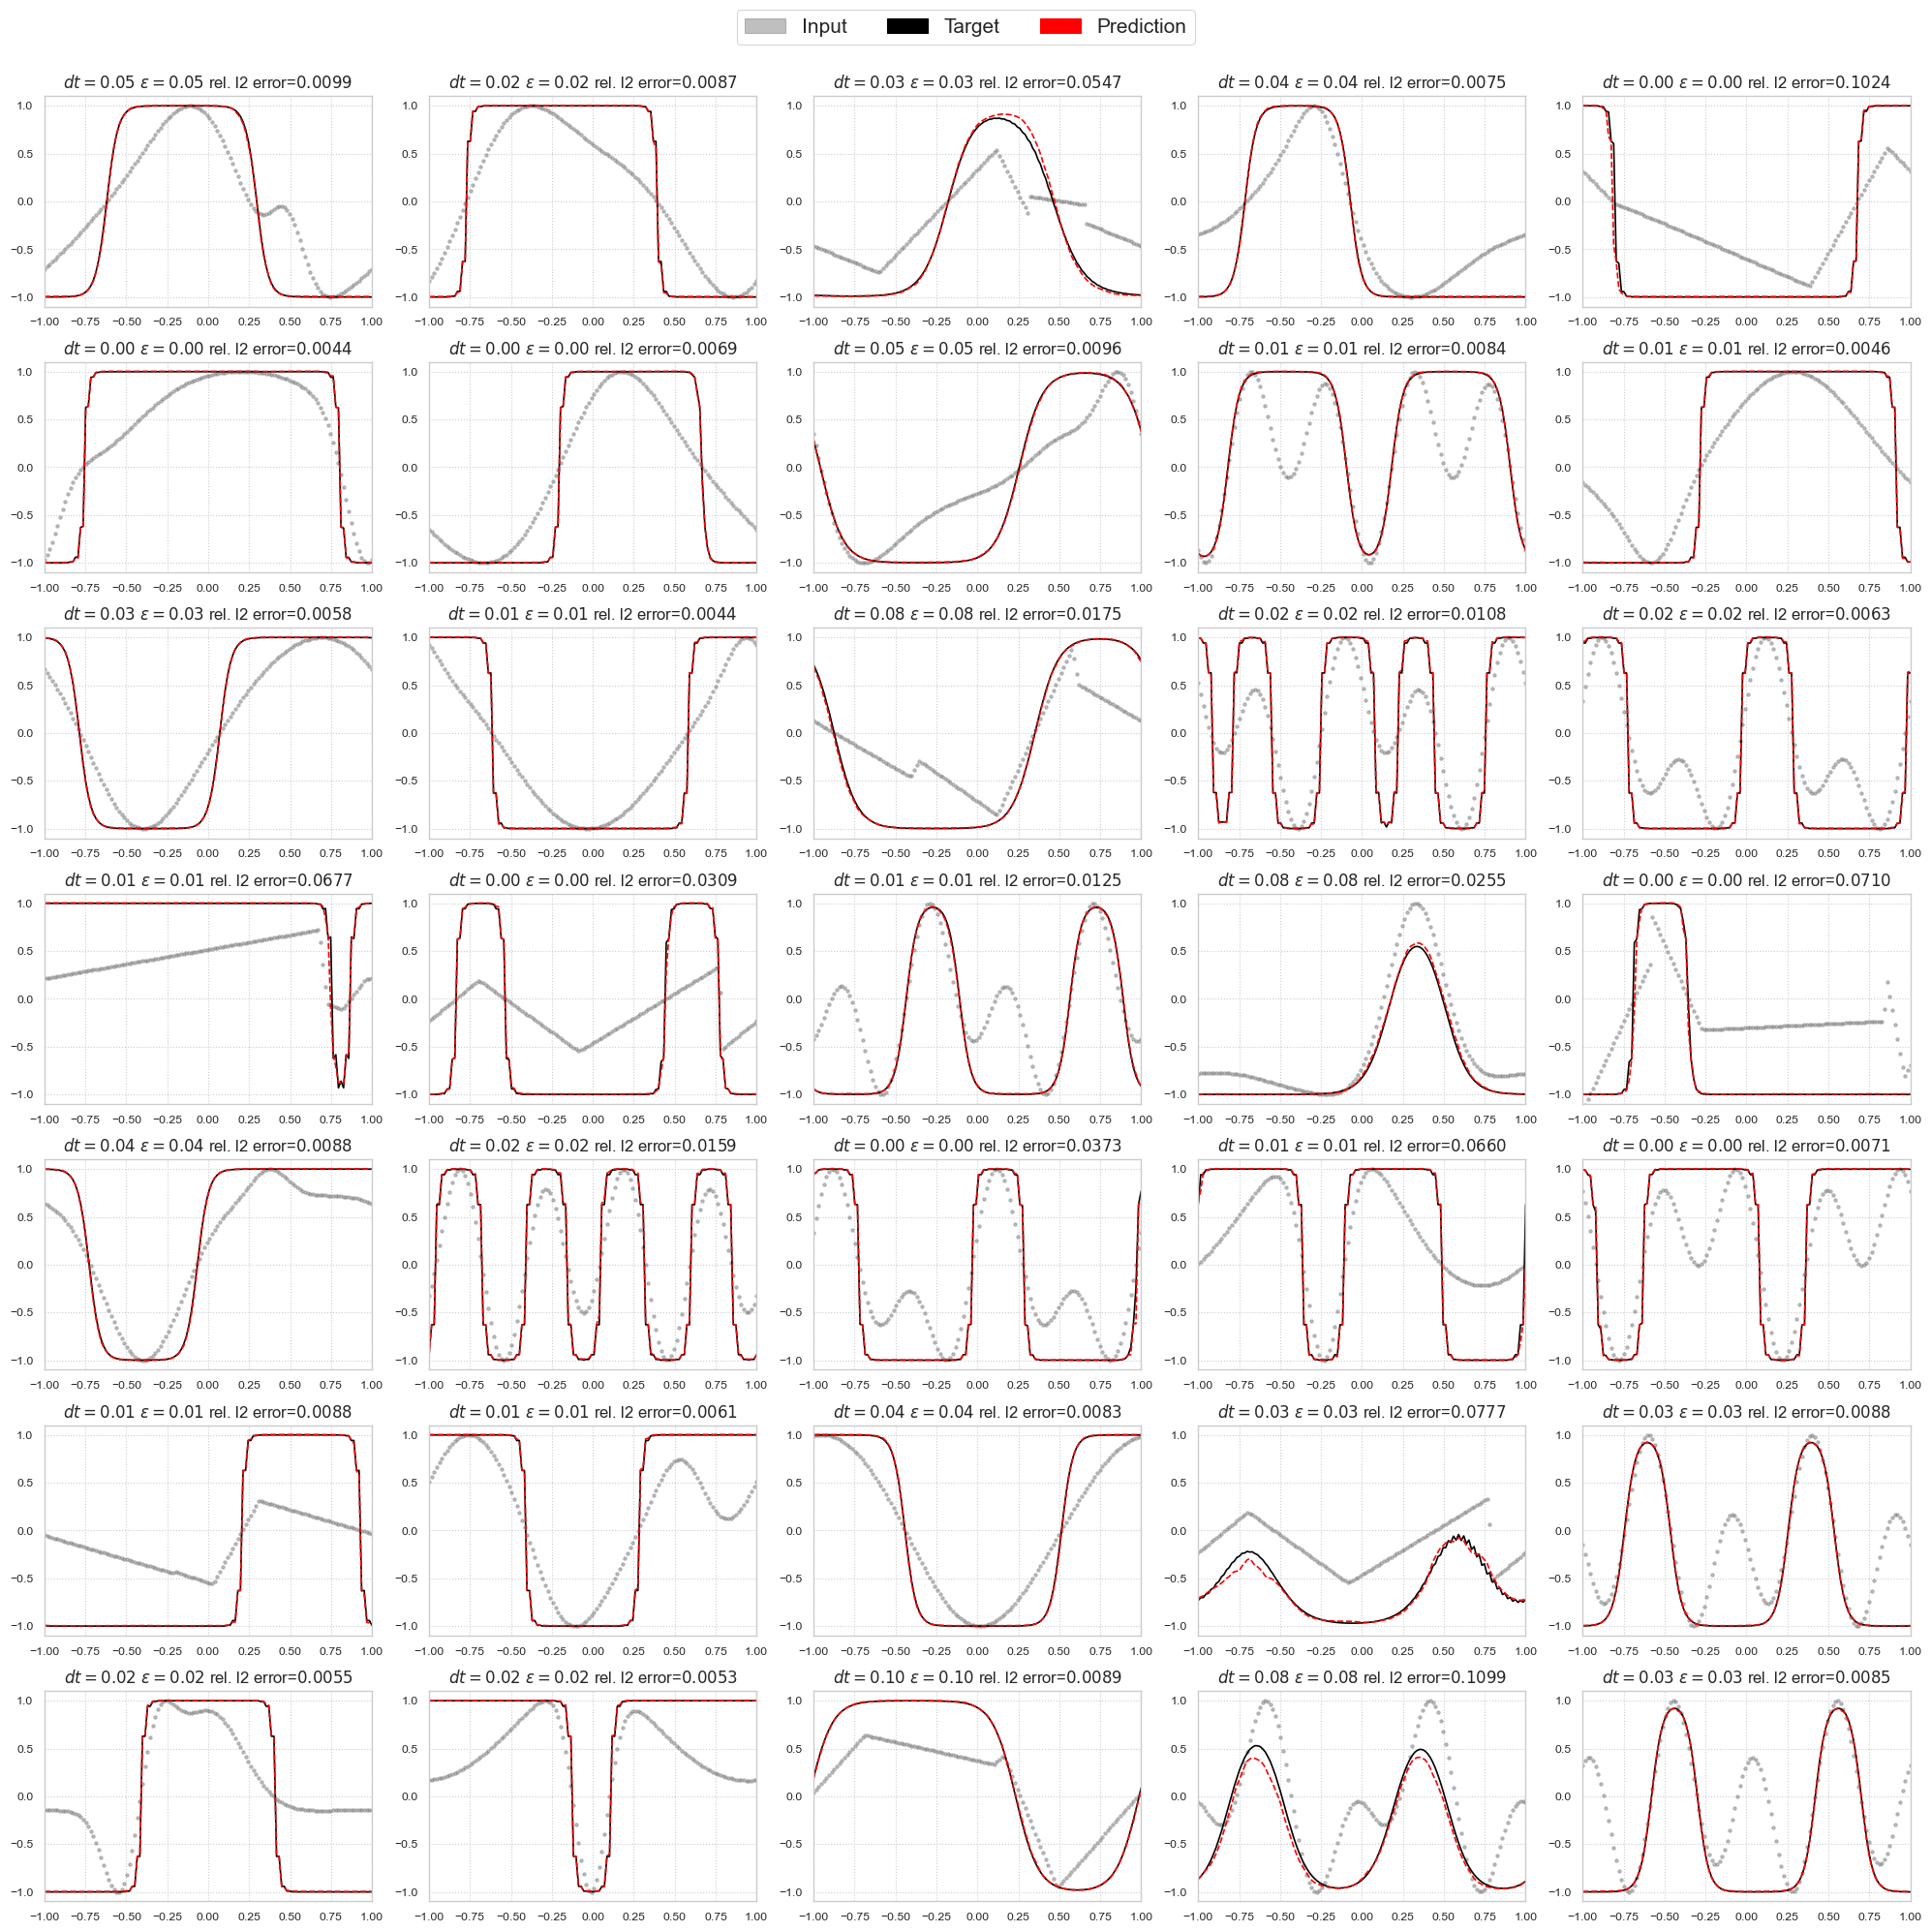

In [18]:
fig, axs = plt.subplots(7, BATCH_SIZE, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, eps, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta, eps)

    target = target

    for j, p in enumerate(prediction):
        epsilon = input_copy[j, :, -1][0].item()
        re_l2_error = relative_l2_error(p.squeeze(-1), target[j], dim=-1)

        ax = ax_rows[j]
        # set limits
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1.1, 1.1)

        ax.set_title(
            rf"$dt={time_delta[j].item():.2f}$ $\epsilon={epsilon:.2f}$ rel. l2 error=${re_l2_error:.4f}$",
            fontsize=12,
        )

        x_grid = np.linspace(-1, 1, 128)

        l1 = ax.scatter(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.5,
            color="gray",
            marker=".",
        )


        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red", linestyle="--")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = [l1, l2, l3]

labels = [l1.get_label(), l2[0].get_label(), l3[0].get_label()]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    try:
        colour = lines[group_idx][0].get_color()
        opac = lines[group_idx][0].get_alpha()
    except TypeError:
        colour = lines[group_idx].get_facecolor()
        opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(
    handles=handles, labels=labels, loc="upper center", ncol=len(labels), fontsize=15
)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig("figures/ac_test_examples.png", dpi=300)
plt.show()